# Kaggle Submission Notebook
## W207 Final Project
### T. P. Goter
### July 26, 2019

This workbook is used to generate predictions on the Kaggle-provided test data and generate some files that can be submitted and scored on Kaggle. This is the final test of our models' accuracies.

In [1]:
# Import needed packages
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import pandas as pd
import numpy as np
import time
from tensorflow.keras import models, layers, callbacks
from tensorflow.keras import optimizers, metrics
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

In [2]:
tf.__version__
tf.keras.backend.clear_session()

## Load the test data 

The test data is a set of 1700+ images. We apparently don't need predictions for all keypoints for every image. There is a look up table with the appropriate RowId, ImageId and Feature to be predicted. So we will generate all of the predictions and then filter our data before writing the submission file.

In [3]:
# Test Data is just Image ID followed by an array of pixel values. 
test_data = pd.read_csv('facial-keypoints-detection/test.csv')

# Display the first few lines of data
print(test_data.head(5))

# Scale the test data for our model
test_X = test_data['Image'].map(lambda x: (np.array(x.split()).astype(int) / 255.0))

# Get the data ready for predicting
test_X = np.array([x.reshape(96,96,1) for x in test_X])

# Look at our array
print(test_X.shape)

# Read in the lookup data
look_up = pd.read_csv('facial-keypoints-detection/IdLookupTable.csv')

# Read in the column headers from the training dataset
df = pd.read_csv('facial-keypoints-detection/training.csv')
keypoints = df.columns[:-1]
X = df['Image'].map(lambda x: (np.array(x.split()).astype(int) / 255.0))
del df

   ImageId                                              Image
0        1  182 183 182 182 180 180 176 169 156 137 124 10...
1        2  76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2        3  177 176 174 170 169 169 168 166 166 166 161 14...
3        4  176 174 174 175 174 174 176 176 175 171 165 15...
4        5  50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
(1783, 96, 96, 1)


## Regenerate the KNR model for official scoring

In [4]:
def knr(k=5, test_X=test_X):

    # Let's create our knn classifier
    knn_model = KNeighborsRegressor(n_neighbors=k)
    
    df = pd.read_pickle('df_nostache_nonan.pkl')
    
    train_X = df['Image'].map(lambda x: x.astype(int) / 255.0)
    train_X = np.array([x for x in train_X])
    train_y = np.array(df.iloc[:,:-1])
    knn_model.fit(train_X, train_y)
    
    # Generate predictions
    test_X = np.array([x.reshape(9216) for x in test_X])
    test_y = knn_model.predict(test_X)
    
    # Throw the predictions in a dataframe
    pred_df = pd.DataFrame(test_y, columns=keypoints)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    name = 'knn'
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)
    
    
    return knn_model, pred_df


## Recreate model because Keras is broken

When specifying the input shape using the Input Layer (as opposed to as part of the first convolution layer) the h5 file saved through the model.save() method in keras will not have the appropriate shape information saved to it. Thus, to actually load these saved models, one needs to rebuild their model (hopefully they remember all the details) and then just bring in the weights from the saved model.

### The function below recreates the models for most of our higher performing AlexNet architecture.

In [5]:
def create_bn_cnn_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

### Recreate our VGG Net Models

In [6]:
def create_vgg_model(start_filter, d, step, bias):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    
    # Input layer is our grayscale image that is 96 pixels by 96 pixels
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    
    # Add our first convolution layers which is two back-to-back conv with 3x3 kernel and same padding
    # Add depth with filters
    # Our output from these convolutions will be (96,96,start_filter)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (48,48,32)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d))
    
    # Add our second convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth - output layer will be (48,48,start_filter*2)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (24,24,start_filter*2)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    
    # Add our third convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (24,24,start_filter*4)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
    
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (12,12,start_filter*4)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Add some random dropout
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    
    # Add our fourth and final convolution layers which is three back-to-back conv with 3x3 kernel and same padding
    # Double filter depth again - output layer will be (12,12,start_filter*8)
    if bias:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), padding='same', activation='relu'))
    else:
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        cnn_model.add(tf.keras.layers.Conv2D(start_filter*8, (3, 3), use_bias=False, 
                                             padding='same', activation='relu'))
        
    # Normalize our features
    cnn_model.add(layers.BatchNormalization())
    
    # Use a max pooling layer to cut our features in half
    # Output size will be (6,6,start_filter*8)
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten and transition to fully connected layers
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(500))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(30))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

### Recreate our Specialist Models

In [7]:
def create_spec_bn_cnn_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (3, 3), padding='valid', 
                                         input_shape=(96, 96, 1),activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (2, 2), padding='valid', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(2, name='Specialist'))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

## Generate our KNR model

In [24]:
knn_model, knn_predictions = knr()

## Load our Alex Net Model without Flipped Data

In [50]:
# Need to rebuild our model - keras won't let us load the model directly due to a bug
model = create_bn_cnn_model(start_filter=12, d=0.0, step=0.00)

# Path to the model - we will just load the weights from it
model_path = 'Models/cnn_lr_adam_d0.0_s0.0_sf12_lrfactor10.h5' 

# Load the weights in
model.load_weights(model_path)

Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_220 (Conv2D)          (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_351 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_211 (MaxPoolin (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_280 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_352 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_212 (MaxPoolin (None, 23, 23, 24)      

## Load our Alex Net Model WITH Flipped Data

In [51]:
# Need to rebuild our model - keras won't let us load the model directly due to a bug
flipped_model = create_bn_cnn_model(start_filter=16, d=0.0, step=0.05)

# Path to the model - we will just load the weights from it
model_path = 'Models/cnn_flipped5_adam_d0.0_s0.05_sf16_lrfactor10_flipped_100.h5' 

# Load the weights in
flipped_model.load_weights(model_path)


Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_223 (Conv2D)          (None, 94, 94, 16)        144       
_________________________________________________________________
batch_normalization_356 (Bat (None, 94, 94, 16)        64        
_________________________________________________________________
max_pooling2d_214 (MaxPoolin (None, 47, 47, 16)        0         
_________________________________________________________________
dropout_284 (Dropout)        (None, 47, 47, 16)        0         
_________________________________________________________________
conv2d_224 (Conv2D)          (None, 46, 46, 32)        2048      
_________________________________________________________________
batch_normalization_357 (Bat (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_215 (MaxPoolin (None, 23, 23, 32)      

In [52]:
flipped_model.predict(test_X)

array([[65.22306 , 37.825733, 28.872261, ..., 68.65794 , 48.229584,
        84.56952 ],
       [67.569084, 36.3578  , 27.90754 , ..., 72.29548 , 48.83529 ,
        87.2562  ],
       [65.96215 , 35.933758, 31.42334 , ..., 70.969765, 49.653862,
        83.934105],
       ...,
       [65.72198 , 39.15886 , 32.375114, ..., 75.20151 , 44.833946,
        78.128494],
       [62.88357 , 35.66554 , 29.585333, ..., 76.34022 , 47.334743,
        77.38356 ],
       [65.81455 , 38.408543, 30.974024, ..., 77.057755, 48.423462,
        84.57026 ]], dtype=float32)

## Load a VGG Net Model

In [12]:
# Need to rebuild our model - keras won't let us load the model directly due to a bug
vgg_model = create_vgg_model(start_filter=16, d=0.0, step=0.02, bias=False)

# Path to the model - we will just load the weights from it
model_path = 'Models/cnn_vgg_flipped4_model_adam_d0.0_s0.02_sf16.h5' 

# Load the weights in
vgg_model.load_weights(model_path)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 96, 96, 16)        144       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 96, 96, 16)        2304      
_________________________________________________________________
batch_normalization_10 (Batc (None, 96, 96, 16)        64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 48, 48, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 48, 48, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 32)        4608      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 48, 48, 32)       

## Recreate our Specialist Models and load the weights


In [13]:
specialist_models = {}
for keypoint in keypoints[::2]:
    # Rebuild the model
    specialist_models[keypoint[:-2]] = create_spec_bn_cnn_model(12, 0, 0.1)
    
    # Get path to current specialist
    spec_model_path = 'Models/cnn_spec_'+keypoint[:-2]+'_d0_s10_sf12_lrfactor1_flipped_100.h5' 

    # Load the weights in
    specialist_models[keypoint[:-2]].load_weights(spec_model_path)
print(specialist_models.keys())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_16 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_17 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 23, 23, 24)       

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_31 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_24 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_32 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 23, 23, 24)       

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_46 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_47 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 23, 23, 24)       

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_61 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_62 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_76 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_77 (Batc (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 23, 23, 24)      

## Specialist Model - Improved Nose and Mouth

In [14]:
improved_specialist_models = {}
improved_specs = {'nose_tip':'cnn_4l_spec_nose_tip_d0.2_s0.15_sf20_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5',
                  'mouth_center_bottom_lip':'cnn_4l_spec_mouth_center_bottom_lip_d0.2_s0.15_sf20_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5'}
for keypoint in keypoints[::2]:
    if keypoint[:-2] not in improved_specs.keys():
        
        print("Loading model weights for {} using original specialist".format(keypoint[:-2]))
        
        # Rebuild the model
        improved_specialist_models[keypoint[:-2]] = create_spec_bn_cnn_model(12, 0, 0.1)

        # Get path to current specialist
        spec_model_path = 'Models/cnn_spec_'+keypoint[:-2]+'_d0_s10_sf12_lrfactor1_flipped_100.h5' 
                  
        # Load the weights in
        improved_specialist_models[keypoint[:-2]].load_weights(spec_model_path)
        
    else:
        print("Loading model for {} using improved specialist".format(keypoint[:-2]))
        spec_model_path = 'Models/' + improved_specs[keypoint[:-2]]          
        improved_specialist_models[keypoint[:-2]] = models.load_model(spec_model_path)
    
print(improved_specialist_models.keys())

Loading model weights for left_eye_center using original specialist
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_64 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_91 (Batc (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_92 (Batc (None, 46, 46, 24)        96        
___________________________________________________

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_73 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_106 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_107 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_121 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_73 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_96 (Dropout)         (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_122 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 23, 23, 24)      

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_136 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_137 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_83 (MaxPooling (None, 23, 23, 24)      

W0803 09:38:09.123613 4542432704 nn_ops.py:4220] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0803 09:38:09.206682 4542432704 nn_ops.py:4220] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Loading model weights for mouth_left_corner using original specialist
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_94 (Conv2D)           (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_141 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_85 (MaxPooling (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_142 (Bat (None, 46, 46, 24)        96        
_________________________________________________

W0803 09:38:18.710724 4542432704 nn_ops.py:4220] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.
W0803 09:38:18.791313 4542432704 nn_ops.py:4220] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


dict_keys(['left_eye_center', 'right_eye_center', 'left_eye_inner_corner', 'left_eye_outer_corner', 'right_eye_inner_corner', 'right_eye_outer_corner', 'left_eyebrow_inner_end', 'left_eyebrow_outer_end', 'right_eyebrow_inner_end', 'right_eyebrow_outer_end', 'nose_tip', 'mouth_left_corner', 'mouth_right_corner', 'mouth_center_top_lip', 'mouth_center_bottom_lip'])


## Specialist Model - Improved Nose, Mouth and Eyes

In [139]:
improved_specialist_models['nose_tip'].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 20)        80        
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 20)        80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 20)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 48, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 40)        7200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 40)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 40)        0

In [25]:
improved_specialist_models_weyes = {}
improved_specs_weyes = {'nose_tip':'cnn_4l_spec_nose_tip_d0.2_s0.15_sf20_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5',
                  'mouth_center_bottom_lip':'cnn_4l_spec_mouth_center_bottom_lip_d0.2_s0.15_sf20_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5',
                  'left_eye_center': 'cnn_4l_spec_left_eye_center_d0.2_s0.2_sf20_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5',
                  'right_eye_center': 'cnn_4l_spec_right_eye_center_d0.0_s0.15_sf6_lrfactor10_flipped_100_fc1200_fc2200_kern2345.h5'}
for keypoint in keypoints[::2]:
    if keypoint[:-2] not in improved_specs_weyes.keys():
        
        print("Loading model weights for {} using original specialist".format(keypoint[:-2]))
        
        # Rebuild the model
        improved_specialist_models_weyes[keypoint[:-2]] = create_spec_bn_cnn_model(12, 0, 0.1)

        # Get path to current specialist
        spec_model_path = 'Models/cnn_spec_'+keypoint[:-2]+'_d0_s10_sf12_lrfactor1_flipped_100.h5' 
                  
        # Load the weights in
        improved_specialist_models_weyes[keypoint[:-2]].load_weights(spec_model_path)
        
    else:
        print("Loading model for {} using improved specialist".format(keypoint[:-2]))
        spec_model_path = 'Models/' + improved_specs_weyes[keypoint[:-2]]          
        improved_specialist_models_weyes[keypoint[:-2]] = models.load_model(spec_model_path)
    
print(improved_specialist_models_weyes.keys())

Loading model for left_eye_center using improved specialist
Loading model for right_eye_center using improved specialist
Loading model weights for left_eye_inner_corner using original specialist
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_181 (Conv2D)          (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_286 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_172 (MaxPoolin (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_228 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_182 (Conv2D)          (None, 46, 46, 24)        1152      
________________________________________________________

Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_190 (Conv2D)          (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_301 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_181 (MaxPoolin (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_240 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_191 (Conv2D)          (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_302 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_182 (MaxPoolin (None, 23, 23, 24)      

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_199 (Conv2D)          (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_316 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_190 (MaxPoolin (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_252 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_200 (Conv2D)          (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_317 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_191 (MaxPoolin (None, 23, 23, 24)      

Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_208 (Conv2D)          (None, 94, 94, 12)        108       
_________________________________________________________________
batch_normalization_331 (Bat (None, 94, 94, 12)        48        
_________________________________________________________________
max_pooling2d_199 (MaxPoolin (None, 47, 47, 12)        0         
_________________________________________________________________
dropout_264 (Dropout)        (None, 47, 47, 12)        0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 46, 46, 24)        1152      
_________________________________________________________________
batch_normalization_332 (Bat (None, 46, 46, 24)        96        
_________________________________________________________________
max_pooling2d_200 (MaxPoolin (None, 23, 23, 24)      

## Generate predictions from our model and write submissions file

In [18]:
def predict_submit_baseline(name='baseline'):
    '''
    This function takes an input model, generates predictions on our test data, and 
    writes a file to be submitted to Kaggle for scoring.
    '''
    
    bl_pred = pd.read_csv('Submissions/baseline_predictions.csv')
    bl_pred = bl_pred.T.reset_index()
    bl_pred.columns = bl_pred.iloc[0]
    bl_pred = bl_pred.drop(0)
    
    # Make our predictions
    test_y = pd.concat([bl_pred]*len(test_X), ignore_index=True)
    
    # Throw the predictions in a dataframe
    pred_df = pd.DataFrame(test_y, columns=keypoints)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)
    
    return pred_df

In [19]:
def predict_submit(model, name='sf12_do0_0_noflip'):
    '''
    This function takes an input model, generates predictions on our test data, and 
    writes a file to be submitted to Kaggle for scoring.
    '''
    # Make our predictions
    test_y = model.predict(test_X)
    
    # Throw the predictions in a dataframe
    pred_df = pd.DataFrame(test_y, columns=keypoints)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)
    
    return pred_df

## Generate predictions from specialist models and write submissions file

In [20]:
def predict_submit_spec(model_dict, name='spec01'):
    '''
    This function takes an input model, generates predictions on our test data, and 
    writes a file to be submitted to Kaggle for scoring.
    '''
    pred_df = pd.DataFrame()
    for key, model in model_dict.items():
    
        # Make our predictions
        test_y = model.predict(test_X)
    
        # Throw the predictions in a dataframe
        temp_df = pd.DataFrame(test_y, columns=[key+'_x', key+'_y'])
        
        # Eliminate negatives and replace with zero
        temp_df[key+'_x'] = temp_df[key+'_x'].map(lambda x: 0 if x < 0 else x)
        temp_df[key+'_y'] = temp_df[key+'_y'].map(lambda x: 0 if x < 0 else x)
        
        # Concatenate the temporary dataframe to the prediction dataframe
        pred_df = pd.concat([pred_df, temp_df], axis=1)
    
    # Now we need to get just the values that kaggle wants by iterating over the look up table
    values = []
    for i, row in look_up.iterrows():
        values.append((row.RowId, pred_df.iloc[row.ImageId-1][row.FeatureName]))
    
    # Write our data to a dataframe and then dump to csv
    sub_df = pd.DataFrame(values, columns=('RowId', 'Location'))
    sub_df.to_csv("Submissions/{}_submission.csv".format(name), index=False)
    
    return pred_df

In [49]:
baseline_predictions = predict_submit_baseline(name='baseline')
base_alex_noflip_predictions = predict_submit(model, name='base_alex_noflip')
base_alex_predictions = predict_submit(flipped_model, name='base_alex')
vgg_predictions = predict_submit(vgg_model, name='vgg_flip')
specialist_predictions = predict_submit_spec(specialist_models)
nose_mouth_predictions = predict_submit_spec(improved_specialist_models, name='imp_mbcl_nt')
nose_mouth_eyes_predictions = predict_submit_spec(improved_specialist_models_weyes, name='imp_mbcl_nt_eyes')

In [70]:
prediction_list = [("Mean Model", baseline_predictions),
                  ("kNR Model", knn_predictions),
                  ("AlexNet Base Model", base_alex_noflip_predictions),
                  ("AlexNet Flipped Image Model", base_alex_predictions),
                  ("VGG Net FI Model", vgg_predictions),
                  ("AlexNet FI Specialist Model", specialist_predictions),
                  ("AlexNet FI Specialist Model (Nose/Mouth)", nose_mouth_predictions),
                  ("AlexNet FI Specialist Model (Nose/Mouth/Eyes)", nose_mouth_eyes_predictions)]

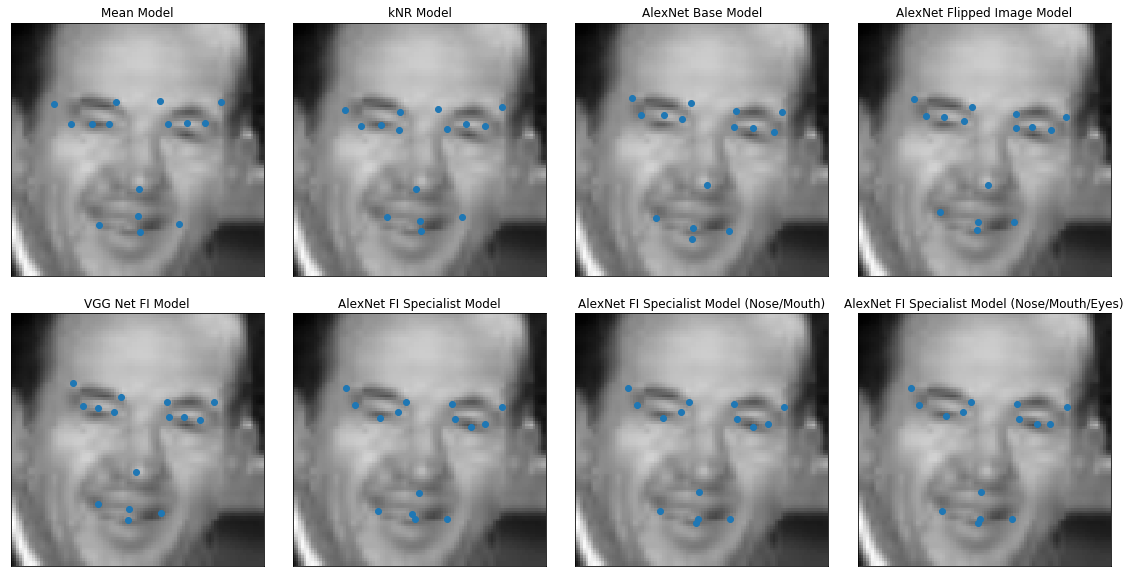

In [73]:
fig, axes = plt.subplots(2,len(prediction_list)//2, figsize=(20,10), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()
for p, (name, pred) in enumerate(prediction_list):
    
    # Show the keypoint predictions for all of our eight models that we submitted for one random image
    axes[p].imshow(test_X[-3].reshape(96,96), cmap='gray')
    axes[p].set_title(name)
    axes[p].scatter(x=pred.iloc[-3,::2].values.astype(float),y=pred.iloc[-3,1::2].values.astype(float))
    
plt.subplots_adjust(wspace=0.05,hspace=0.15)

1066


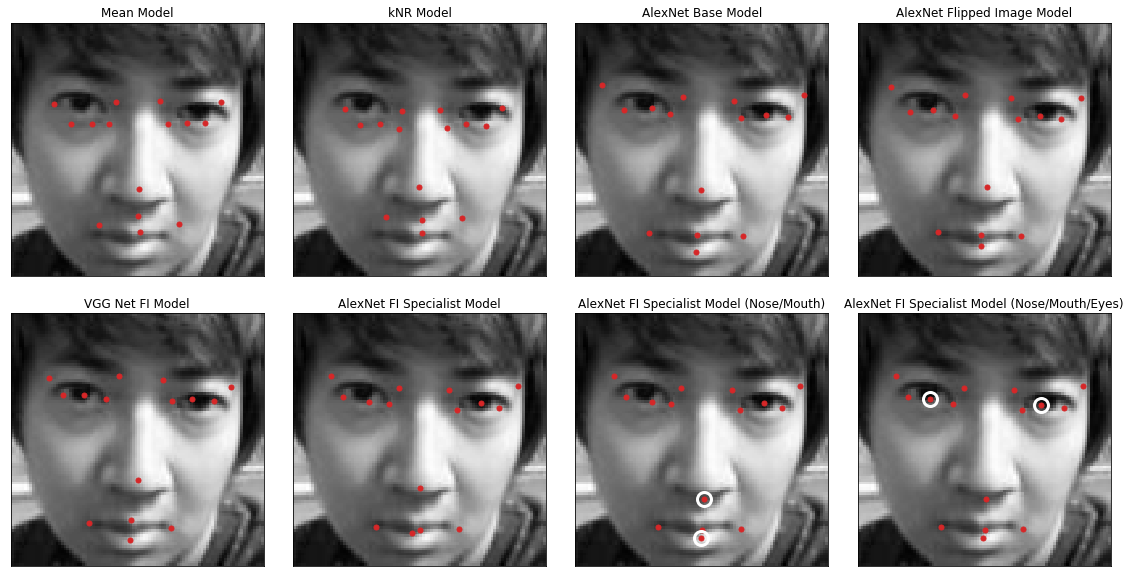

In [355]:
fig, axes = plt.subplots(2,len(prediction_list)//2, figsize=(20,10), subplot_kw={'xticks': [], 'yticks': []})
# Grab a random image
im_num = np.random.randint(len(test_X))
print(im_num)
axes = axes.flatten()
for p, (name, pred) in enumerate(prediction_list):
    
    # Show the keypoint predictions for all of our eight models that we submitted for one random image
    axes[p].imshow(test_X[im_num].reshape(96,96), cmap='gray')
    axes[p].set_title(name)
    axes[p].scatter(x=pred.iloc[im_num,::2].values.astype(float),
                    y=pred.iloc[im_num,1::2].values.astype(float),
                    c='tab:red', s=25)
    if (p==len(prediction_list)-2):
        axes[p].plot(pred.iloc[im_num,-10], pred.iloc[im_num,-9], 'ro',
                         markerfacecolor="None", markeredgecolor='white',
                         linestyle='', ms=14, mew=3)
        axes[p].plot(pred.iloc[im_num,-2], pred.iloc[im_num,-1], 'ro',
                         markerfacecolor="None", markeredgecolor='white',
                         linestyle='', ms=14, mew=3)
    elif (p==len(prediction_list)-1):
        axes[p].plot(pred.iloc[im_num,0], pred.iloc[im_num,1], 'ro',
                         markerfacecolor="None", markeredgecolor='white',
                         linestyle='', ms=14, mew=3)
        axes[p].plot(pred.iloc[im_num,2], pred.iloc[im_num,3], 'ro',
                         markerfacecolor="None", markeredgecolor='white',
                         linestyle='', ms=14, mew=3)
plt.subplots_adjust(wspace=0.05,hspace=0.15)

In [206]:
1116

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

989


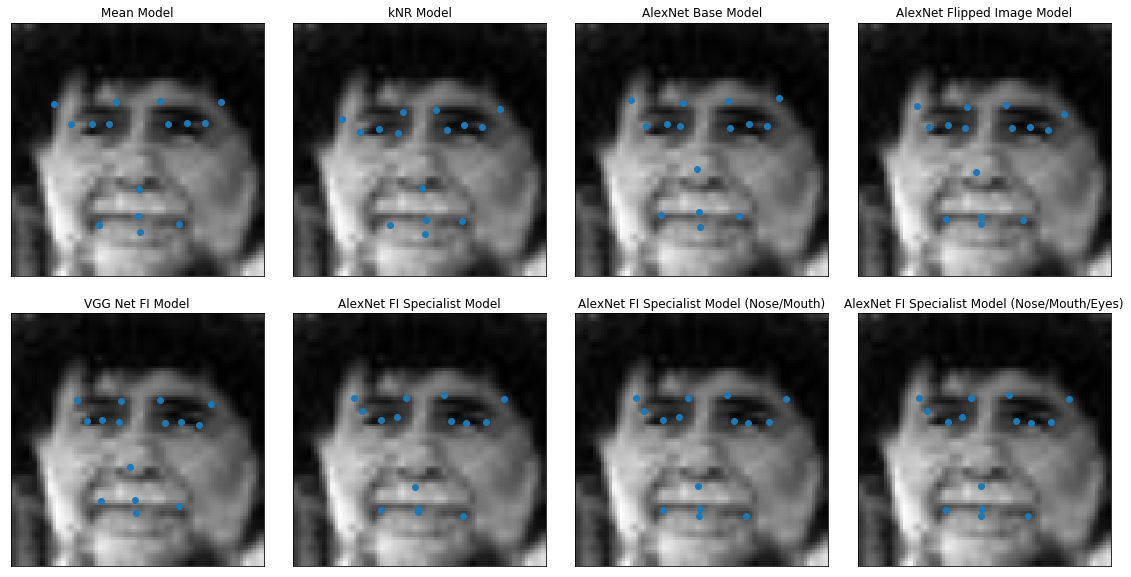

In [187]:
fig, axes = plt.subplots(2,len(prediction_list)//2, figsize=(20,10), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()
# Grab a random image
im_num = np.random.randint(len(test_X))
print(im_num)
for p, (name, pred) in enumerate(prediction_list):
    # Show the keypoint predictions for all of our eight models that we submitted for one random image
    axes[p].imshow(test_X[im_num].reshape(96,96), cmap='gray')
    axes[p].set_title(name)
    axes[p].scatter(x=pred.iloc[im_num,::2].values.astype(float),y=pred.iloc[im_num,1::2].values.astype(float))
    
plt.subplots_adjust(wspace=0.05,hspace=0.15)

In [8]:
kaggle_scores = [("Mean Model", 3.78050, 3.96347),
                  ("kNR Model", 4.16837, 4.29575),
                  ("AlexNet Base Model", 2.88829, 2.99322) ,
                   ("AlexNet Flipped Image", 2.75529, 2.86753),
                   ("VGG Net FI", 2.83031, 2.92438),
                  ("ANet FI Spec.", 1.77859, 2.17985),
                 ("ANet FI Spec. 2", 1.70979, 2.08835),
                 ("ANet FI Spec. 3", 1.72169, 2.05074),
                 ("Inception", 3.16997, 3.23041),
                 ("ResNet", 3.25493, 3.31251),
                 ("MobileNet", 2.59635, 2.77193)]

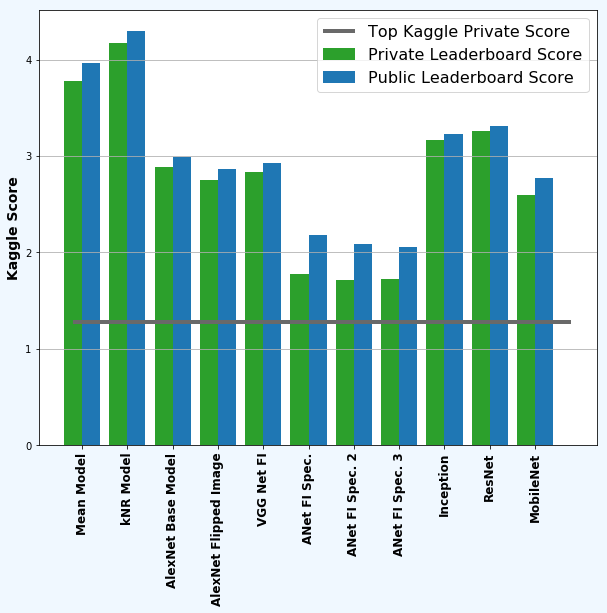

In [10]:
bar_width = 0.40
index = np.arange(len(kaggle_scores))
fig, ax = plt.subplots(1,1, figsize=(10,8))
fig.patch.set_facecolor('aliceblue')
ax.bar(index, [score[1] for score in kaggle_scores], bar_width, 
       color='tab:green', label="Private Leaderboard Score")
ax.bar(index+bar_width, [score[2] for score in kaggle_scores], bar_width, 
       color='tab:blue', label="Public Leaderboard Score")
ax.set_xticks(index+bar_width/2)
ax.set_xticklabels((score[0] for score in kaggle_scores), rotation=90, fontweight='bold', fontsize=12)
ax.set_ylabel("Kaggle Score", fontsize=14, fontweight='bold')
ax.hlines(1.28, 0, 11, colors='dimgrey', label="Top Kaggle Private Score",linewidth=4)
ax.grid(True, axis='y')
ax.legend(fontsize=16)


In [140]:
def create_4layer_spec_model(start_filter, d, step, fc1=500, fc2=500):
    '''
    Simple function that retruns a keras cnn model 
    '''
    cnn_model = tf.keras.models.Sequential()
    cnn_model.add(tf.keras.layers.InputLayer(input_shape=(96, 96, 1)))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter, (2, 2), padding='same', 
                                         input_shape=(96, 96, 1),activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*2, (3, 3), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*4, (4, 4), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+2*step))
    cnn_model.add(tf.keras.layers.Conv2D(start_filter*5, (5, 5), padding='same', activation='relu', use_bias=False))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Flatten())
    cnn_model.add(tf.keras.layers.Dense(fc1))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Dropout(d+3*step))
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(fc2))
    cnn_model.add(layers.BatchNormalization())
    cnn_model.add(tf.keras.layers.Activation('relu'))
    cnn_model.add(tf.keras.layers.Dense(2, name='Specialist'))
    cnn_model.add(tf.keras.layers.Activation('linear'))

    print(50*"=")
    print(cnn_model.summary())
    print(50*"=")
    
    return cnn_model

In [142]:
test_model = create_4layer_spec_model(20,.2,.15,200,200)

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_226 (Conv2D)          (None, 96, 96, 20)        80        
_________________________________________________________________
batch_normalization_361 (Bat (None, 96, 96, 20)        80        
_________________________________________________________________
max_pooling2d_217 (MaxPoolin (None, 48, 48, 20)        0         
_________________________________________________________________
dropout_288 (Dropout)        (None, 48, 48, 20)        0         
_________________________________________________________________
conv2d_227 (Conv2D)          (None, 48, 48, 40)        7200      
_________________________________________________________________
batch_normalization_362 (Bat (None, 48, 48, 40)        160       
_________________________________________________________________
max_pooling2d_218 (MaxPoolin (None, 24, 24, 40)      

In [143]:
test_model.plot_model()

AttributeError: 'Sequential' object has no attribute 'plot_model'